# Assignment 2

## Setup

*For reference, I was initially running on Cheaha with 16 cores each at 4 GB of memory. Once I got to VGG16 however, I had to move to Google Colab running on a T4 GPU for quicker run times. This was probably because the number of layers in VGG16 is much higher compared to AlexNet (almost triple). I tried to get amperenodes gpu working on Cheaha Jupyter Notebook Server with no success. The notebook kept saying that there was no CUDA drivers found.*

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense, BatchNormalization

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split

# This is needed if using environment/Cheaha session with only CPU(s) and no GPU(s)
# Get list of available GPUs, if they exist
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set all GPUs as visible if they are not already
        tf.config.set_visible_devices(gpus, 'GPU')
        # Get list of devices available to TensorFlow
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs found, using CPU instead")
    # Hiding all GPUs by making list empty
    tf.config.set_visible_devices([], 'GPU')

No GPUs found, using CPU instead


## MINI CIFAR-10

### Creating Training, Validation, Testing Datasets: Using scikit-learn

In [34]:
# Load the CIFAR10 dataset
# x_train/test stores all the image data
# y_train/test stores the label (0-9) for that image (airplane, bird, dog, etc.)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Choose the first 150 images in each class (0-9)
classes = range(10)
selected_images = []
selected_labels = []

for category in classes:
    indices = np.where(y_train == category)[0][:150]  # Get the first 150 indices of images from the current class target
    selected_images.extend(x_train[indices])  # Add each of the selected images to the list of selected images
    selected_labels.extend(y_train[indices])  # Add each of the corresponding labels to the list of selected labels

# Convert to numpy arrays for train_test_split
selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

# Split the mini dataset into train (60%), validation (20%), and test (20%) sets with equal class distribution
# Stratify ensures that the training and test datasets have the same distribution of class labels as the input dataset
# First split the dataset into training (60%) and a temporary set (which would be 100 - 60 = 40%)
x_train_mini, x_temp, y_train_mini, y_temp = train_test_split(selected_images, selected_labels, test_size = 0.4, stratify = selected_labels)
# Then split the temporary set into the two sets, testing and validation, which are each 20% (or 0.5 of 40%)
x_val_mini, x_test_mini, y_val_mini, y_test_mini = train_test_split(x_temp, y_temp, test_size = 0.5, stratify = y_temp)

# Normalize images to [0,1]
x_train_mini = x_train_mini / 255.0
x_val_mini = x_val_mini / 255.0
x_test_mini = x_test_mini / 255.0

print("x_train_mini:", x_train_mini.shape)
print("y_train_mini:", y_train_mini.shape)

print("\nx_val_mini:", x_val_mini.shape)
print("y_val_mini:", y_val_mini.shape)

print("\nx_test_mini:", x_test_mini.shape)
print("y_test_mini:", y_test_mini.shape)


x_train_mini: (900, 32, 32, 3)
y_train_mini: (900, 1)

x_val_mini: (300, 32, 32, 3)
y_val_mini: (300, 1)

x_test_mini: (300, 32, 32, 3)
y_test_mini: (300, 1)


### Creating Training, Validation, Testing Datasets: Using PyTorch

Ended up using this method since PyTorch had more supported pretrained CNN architectures than Keras. The `train_test_split` method from scikit-learn used above outputs NumPy arrays by default. However, PyTorch methods can't take in NumPy arrays unless you first use `torch.from_numpy()` to convert them to tensors. But, I decided to just use PyTorch's methods for splitting data into training, validation, and testing datasets, shown below since it is just as easy as using scikit-learn.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to AlexNet input image size (224x224 pixels)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset to folder called data
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # transform image
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Create MINI CIFAR-10
mini_indices = []
class_counts = [0] * 10
for i, (image, label) in enumerate(training_dataset):
    if class_counts[label] < 150:
        mini_indices.append(i)
        class_counts[label] += 1
mini_dataset = Subset(training_dataset, mini_indices)

In [ ]:
# Define split sizes (60% train, 20% validation, 20% test)
train_size = int(0.6 * len(mini_dataset))
val_size = int(0.2 * len(mini_dataset))
test_size = int(0.2 * len(mini_dataset))

# Create subsets from mini_dataset
train_mini, val_mini, test_mini = random_split(mini_dataset, [train_size, val_size, test_size])

print("train_mini:", len(train_mini), "by", len(train_mini[0]), "(image + label)")
print("val_mini:", len(val_mini), "by", len(val_mini[0]))
print("test_mini:", len(test_mini), "by", len(test_mini[0]))

train_mini: 900 by 2 (image + label)
val_mini: 300 by 2
test_mini: 300 by 2


PyTorch `DataLoader` is a wrapper for datasets that allows for commonly used functionality such as batching, shuffling, and CPU parallelization.

In [ ]:
# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_mini, batch_size=32, shuffle=True)
val_loader = DataLoader(val_mini, batch_size=32, shuffle=False)
test_loader = DataLoader(test_mini, batch_size=32, shuffle=False)

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, test_loader, learning_rate, epochs):

    # Need to define GPU usage before defining anything else
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # This criterion calculates the cross entropy loss (common loss function for classification tasks)
    # between inputs and target values
    criterion = nn.CrossEntropyLoss()

    # Use popular Adam optimizer (Adaptive Moment Estimation) which adapts learning rate for each parameter
    # based on past gradients
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize losses arrays
    train_losses = []
    val_losses = []
    test_losses = []

    # Define device to use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Define device here

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            # Move images and labels to the appropriate device
            images, labels = images.to(device), labels.to(device) # Move to device

            optimizer.zero_grad() # Sets gradients of all model parameters to zero, otherwise past gradients would accumalate
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss using cross entropy criterion
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        #torch.nograd() is important for validation/testing where gradients do not need to be calculated
        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to the appropriate device
                images, labels = images.to(device), labels.to(device) # Move to device

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        test_loss = 0.0
        with torch.no_grad():
             for images, labels in test_loader:
                # Move images and labels to the appropriate device
                images, labels = images.to(device), labels.to(device) # Move to device

                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, val_losses, test_losses

## Q1: AlexNet

In [ ]:
# Load the pretrained AlexNet model using pytorch as keras does not have a pretrained AlexNet model
alexnet_model = torchvision.models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1') # Use the ImageNet weights

Set the model to evaluation mode since the model is already trained. Evaluation mode disables dropout layers. For AlexNet, dropout layers are layers where some neurons in that layer are disabled with a chance 0.5. Dropout is important when training to reduce overfitting but for testing we want to use all available neurons. Evaluation mode also disables batch normalization layers which during training uses the batch mean & variance for normalzing the current batch, but during testing we want to use the overall running mean and variance for normalization so that so that during testing we have a stable normalization method based on precomputed values for mean and variance. Batches are no longer normalized indepedently from their own mean and variance.

In [ ]:
alexnet_model.eval()

# Print the architecture for comparing to other architectures
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Modify the last layer (output layer) for 10 classes (to match with CIFAR-10)
alexnet_model.classifier[6] = nn.Linear(4096, 10)

# Train with original learning rate from AlexNet paper
learning_rate_original = 0.01
epochs = 30
train_losses_original, val_losses_original, test_losses_original = train_and_evaluate(alexnet_model, train_loader, val_loader, test_loader, learning_rate_original, epochs)

Epoch 1/30, Train Loss: 2685.7924, Val Loss: 19.5442, Test Loss: 17.6643
Epoch 2/30, Train Loss: 160.1156, Val Loss: 9.5204, Test Loss: 8.8335
Epoch 3/30, Train Loss: 98.4983, Val Loss: 2.3048, Test Loss: 2.3034
Epoch 4/30, Train Loss: 27.1491, Val Loss: 2.3038, Test Loss: 2.3042
Epoch 5/30, Train Loss: 10.3798, Val Loss: 2.3024, Test Loss: 2.3053
Epoch 6/30, Train Loss: 4.3504, Val Loss: 2.3028, Test Loss: 2.3062
Epoch 7/30, Train Loss: 5.7816, Val Loss: 2.3028, Test Loss: 2.3072
Epoch 8/30, Train Loss: 3.4069, Val Loss: 2.3026, Test Loss: 2.3073
Epoch 9/30, Train Loss: 3.7165, Val Loss: 2.3031, Test Loss: 2.3083
Epoch 10/30, Train Loss: 3.6471, Val Loss: 2.3030, Test Loss: 2.3078
Epoch 11/30, Train Loss: 2.6458, Val Loss: 2.3045, Test Loss: 2.3088
Epoch 12/30, Train Loss: 4.4411, Val Loss: 2.3047, Test Loss: 2.3096
Epoch 13/30, Train Loss: 3.6361, Val Loss: 2.3051, Test Loss: 2.3098
Epoch 14/30, Train Loss: 2.6445, Val Loss: 2.3057, Test Loss: 2.3108
Epoch 15/30, Train Loss: 3.5236, 

In [ ]:
# Train with new learning rate
learning_rate_new = 0.0001
alexnet_new = torchvision.models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
alexnet_new.eval()
alexnet_new.classifier[6] = nn.Linear(4096, 10)
train_losses_increased, val_losses_increased, test_losses_increased = train_and_evaluate(alexnet_new, train_loader, val_loader, test_loader, learning_rate_new, epochs)

Epoch 1/30, Train Loss: 1.5979, Val Loss: 1.0605, Test Loss: 1.1091
Epoch 2/30, Train Loss: 0.7645, Val Loss: 0.9365, Test Loss: 1.0432
Epoch 3/30, Train Loss: 0.4784, Val Loss: 0.9234, Test Loss: 0.9064
Epoch 4/30, Train Loss: 0.2560, Val Loss: 0.9094, Test Loss: 0.9206
Epoch 5/30, Train Loss: 0.1157, Val Loss: 1.0455, Test Loss: 1.1106
Epoch 6/30, Train Loss: 0.1066, Val Loss: 1.0183, Test Loss: 1.1205
Epoch 7/30, Train Loss: 0.1495, Val Loss: 1.1195, Test Loss: 1.0367
Epoch 8/30, Train Loss: 0.1348, Val Loss: 1.0571, Test Loss: 1.0288
Epoch 9/30, Train Loss: 0.0358, Val Loss: 1.0715, Test Loss: 1.0162
Epoch 10/30, Train Loss: 0.0264, Val Loss: 1.1643, Test Loss: 1.1445
Epoch 11/30, Train Loss: 0.1213, Val Loss: 1.1722, Test Loss: 1.1195
Epoch 12/30, Train Loss: 0.0634, Val Loss: 1.0953, Test Loss: 1.1533
Epoch 13/30, Train Loss: 0.0225, Val Loss: 1.1390, Test Loss: 1.0917
Epoch 14/30, Train Loss: 0.0068, Val Loss: 1.1778, Test Loss: 1.1979
Epoch 15/30, Train Loss: 0.0138, Val Loss: 

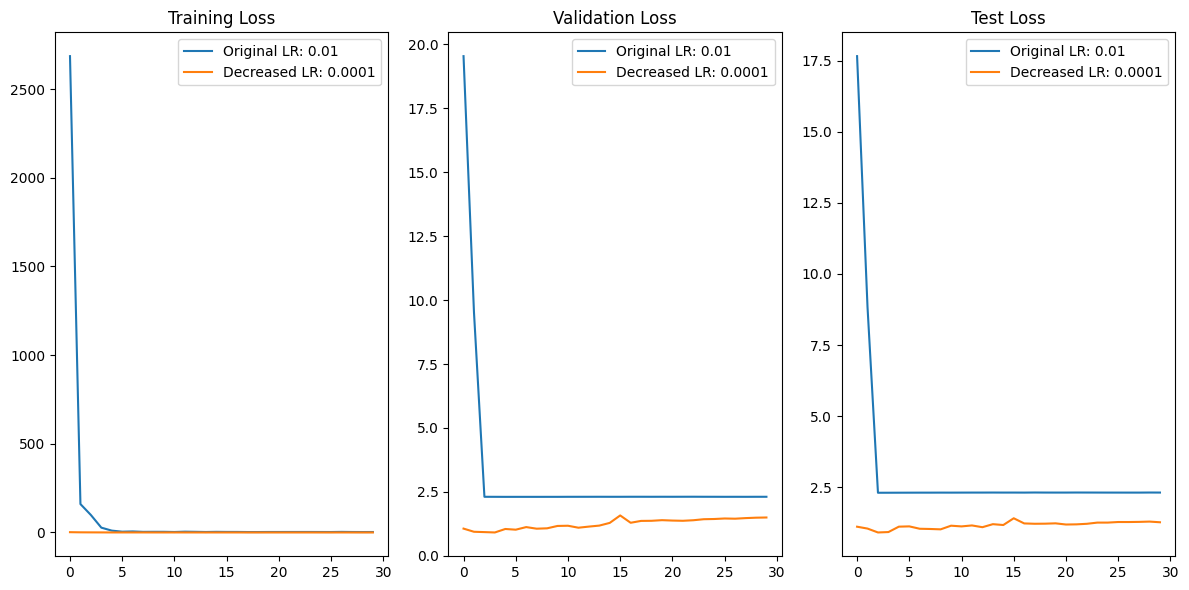

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses_original, label='Original LR: 0.01')
plt.plot(train_losses_increased, label='Decreased LR: 0.0001')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses_original, label='Original LR: 0.01')
plt.plot(val_losses_increased, label='Decreased LR: 0.0001')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_losses_original, label='Original LR: 0.01')
plt.plot(test_losses_increased, label='Decreased LR: 0.0001')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Q2: VGG16

In [ ]:
# Load the pretrained VGG-16 model
vgg16_model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1') # Use the ImageNet weights

# Enable GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

vgg16_model.eval()

# Print the architecture for comparing to other architectures
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Modify the last layer (output layer) for 10 classes (to match with CIFAR-10)
vgg16_model.classifier[6] = nn.Linear(4096, 10)

learning_rate_original = 0.01
epochs = 15 # Had to decrease from 30 epochs to 15, as run time was taking too long
train_losses_original, val_losses_original, test_losses_original = train_and_evaluate(vgg16_model, train_loader, val_loader, test_loader, learning_rate_original, epochs)

Epoch 1/15, Train Loss: 108823596.6427, Val Loss: 469.2587, Test Loss: 500.5802
Epoch 2/15, Train Loss: 214.3248, Val Loss: 25.3253, Test Loss: 26.3588
Epoch 3/15, Train Loss: 8.8495, Val Loss: 2.4279, Test Loss: 2.3970
Epoch 4/15, Train Loss: 2.3819, Val Loss: 2.3354, Test Loss: 2.3245
Epoch 5/15, Train Loss: 2.3795, Val Loss: 2.3746, Test Loss: 2.3286
Epoch 6/15, Train Loss: 2.3246, Val Loss: 2.3590, Test Loss: 2.3120
Epoch 7/15, Train Loss: 2.4688, Val Loss: 2.4583, Test Loss: 2.4690
Epoch 8/15, Train Loss: 2.3914, Val Loss: 2.3423, Test Loss: 2.3601
Epoch 9/15, Train Loss: 2.3258, Val Loss: 2.3361, Test Loss: 2.2997
Epoch 10/15, Train Loss: 2.3205, Val Loss: 2.3020, Test Loss: 2.3404
Epoch 11/15, Train Loss: 2.3103, Val Loss: 2.3090, Test Loss: 2.3033
Epoch 12/15, Train Loss: 2.3097, Val Loss: 2.3116, Test Loss: 2.3226
Epoch 13/15, Train Loss: 2.3131, Val Loss: 2.3266, Test Loss: 2.3165
Epoch 14/15, Train Loss: 2.3107, Val Loss: 2.3163, Test Loss: 2.3065
Epoch 15/15, Train Loss: 2.

In [ ]:
# Create new model with increased learning rate and additional dropout layer
learning_rate_new = 0.1
epochs = 15;
vgg16_new = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1') # Use the ImageNet weights

# Enable GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_new.to(device)

# Convert features (model layers) to a list
features = list(vgg16_new.features)

#(features): Sequential(
    #(0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    #(1): ReLU(inplace=True)
    #(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    #(3): ReLU(inplace=True)
    #(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    #(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    #(6): ReLU(inplace=True)
    # Insert Dropout Layer here --> (7): Dropout(inplace=False)
# Insert Dropout layer after the 3rd Conv layer (ReLU layers are also included)
features.insert(7, nn.Dropout())  # Default dropout probability of 50%

# Reassign the modified features back to the model
vgg16_new.features = nn.Sequential(*features)

vgg16_new.eval()
vgg16_new.classifier[6] = nn.Linear(4096, 10)

# Print the new architecture for verification
print(vgg16_new)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace=True)
    (17): MaxPool2d(kernel

In [ ]:
# Train with increased learning rate
train_losses_increased, val_losses_increased, test_losses_increased = train_and_evaluate(vgg16_new, train_loader, val_loader, test_loader, learning_rate_new, epochs)

Epoch 1/15, Train Loss: 14785727360740398494384128.0000, Val Loss: 8705098771720257614643200.0000, Test Loss: 7812842558303628383223808.0000
Epoch 2/15, Train Loss: 5071488467921038286520320.0000, Val Loss: 2763943441936854301016064.0000, Test Loss: 2486107272844482116059136.0000
Epoch 3/15, Train Loss: 1943824734926889184919552.0000, Val Loss: 1346350186265206040035328.0000, Test Loss: 1175317790261610018766848.0000
Epoch 4/15, Train Loss: 1601803021931106336243712.0000, Val Loss: 1536147489443226706771968.0000, Test Loss: 1318676726682278460129280.0000
Epoch 5/15, Train Loss: 1117889370957446301876224.0000, Val Loss: 740143904219098825883648.0000, Test Loss: 614697451649784851988480.0000
Epoch 6/15, Train Loss: 465460076336984757370880.0000, Val Loss: 341659201427630945468416.0000, Test Loss: 341354523905640076673024.0000
Epoch 7/15, Train Loss: 339795101659516861677568.0000, Val Loss: 247895307425210301415424.0000, Test Loss: 248828420842084137697280.0000
Epoch 8/15, Train Loss: 220

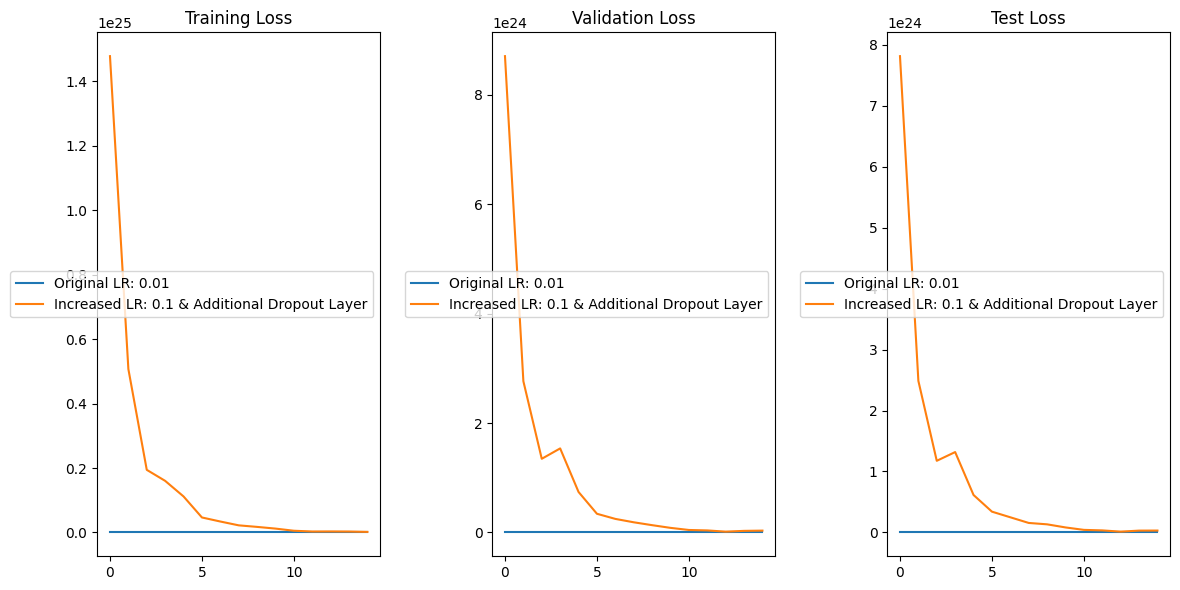

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses_original, label='Original LR: 0.01')
plt.plot(train_losses_increased, label='Increased LR: 0.1 & Additional Dropout Layer')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses_original, label='Original LR: 0.01')
plt.plot(val_losses_increased, label='Increased LR: 0.1 & Additional Dropout Layer')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_losses_original, label='Original LR: 0.01')
plt.plot(test_losses_increased, label='Increased LR: 0.1 & Additional Dropout Layer')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

*I had to plot the model with a learning rate of 0.01 separately as the losses were on a much smaller magnitude when compared to the model with learning rate of 0.1 and an additional dropout layer.*

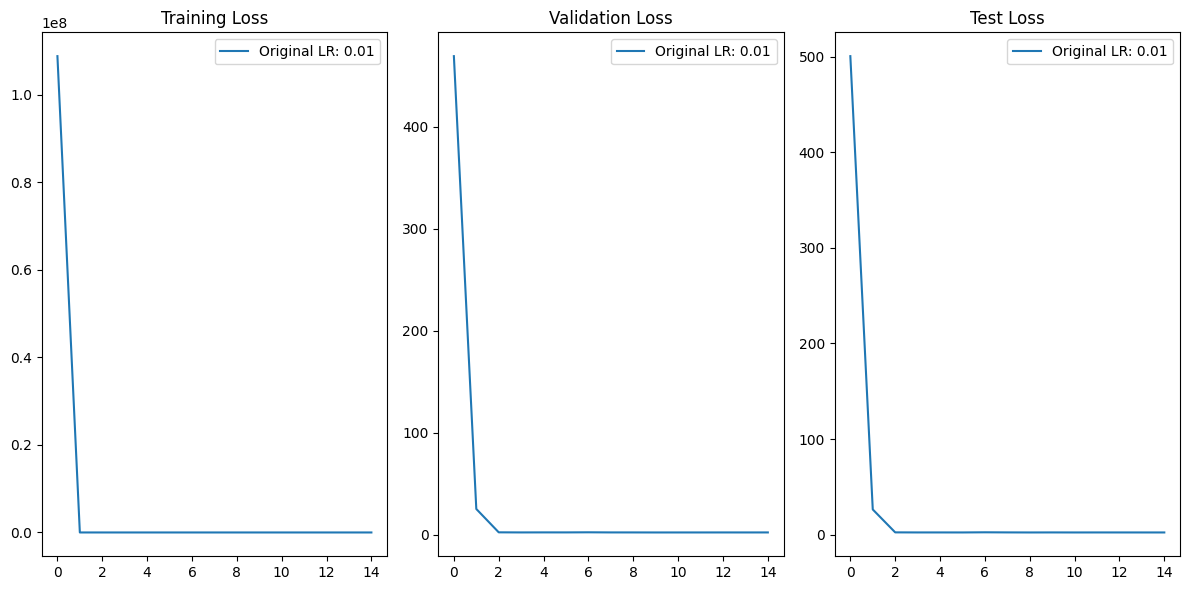

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses_original, label='Original LR: 0.01')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses_original, label='Original LR: 0.01')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_losses_original, label='Original LR: 0.01')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Q3: RESNET50

In [ ]:
# Load the pretrained ResNet50 model
resnet50_model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1') # Use the ImageNet weights

# Enable GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_model.to(device)

resnet50_model.eval()

# Print the architecture for comparing to other architectures
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Modify the last layer (fully connected [fc] layer) for 10 classes (to match with CIFAR-10)
resnet50_model.fc = nn.Linear(2048, 10) # 2048 input features to match output of avgpool layer

epochs = 30
learning_rate_resnet = 0.01
train_losses_resnet, val_losses_resnet, test_losses_resnet = train_and_evaluate(resnet50_model, train_loader, val_loader, test_loader, learning_rate_resnet, epochs)

Epoch 1/30, Train Loss: 3.3389, Val Loss: 3.0952, Test Loss: 2.8589
Epoch 2/30, Train Loss: 2.5215, Val Loss: 2.3867, Test Loss: 2.4135
Epoch 3/30, Train Loss: 2.2685, Val Loss: 2.2658, Test Loss: 2.2925
Epoch 4/30, Train Loss: 2.1974, Val Loss: 2.1798, Test Loss: 2.1448
Epoch 5/30, Train Loss: 2.0723, Val Loss: 2.1984, Test Loss: 2.1276
Epoch 6/30, Train Loss: 2.0557, Val Loss: 2.0656, Test Loss: 2.1372
Epoch 7/30, Train Loss: 2.0461, Val Loss: 2.0723, Test Loss: 2.1009
Epoch 8/30, Train Loss: 2.0340, Val Loss: 2.1056, Test Loss: 2.0910
Epoch 9/30, Train Loss: 2.0128, Val Loss: 2.1164, Test Loss: 2.0860
Epoch 10/30, Train Loss: 1.9851, Val Loss: 2.0427, Test Loss: 2.0617
Epoch 11/30, Train Loss: 2.0208, Val Loss: 2.0321, Test Loss: 2.0449
Epoch 12/30, Train Loss: 1.9936, Val Loss: 2.0590, Test Loss: 2.0969
Epoch 13/30, Train Loss: 2.0008, Val Loss: 2.0676, Test Loss: 2.0480
Epoch 14/30, Train Loss: 1.9607, Val Loss: 2.0008, Test Loss: 2.0150
Epoch 15/30, Train Loss: 1.9468, Val Loss: 

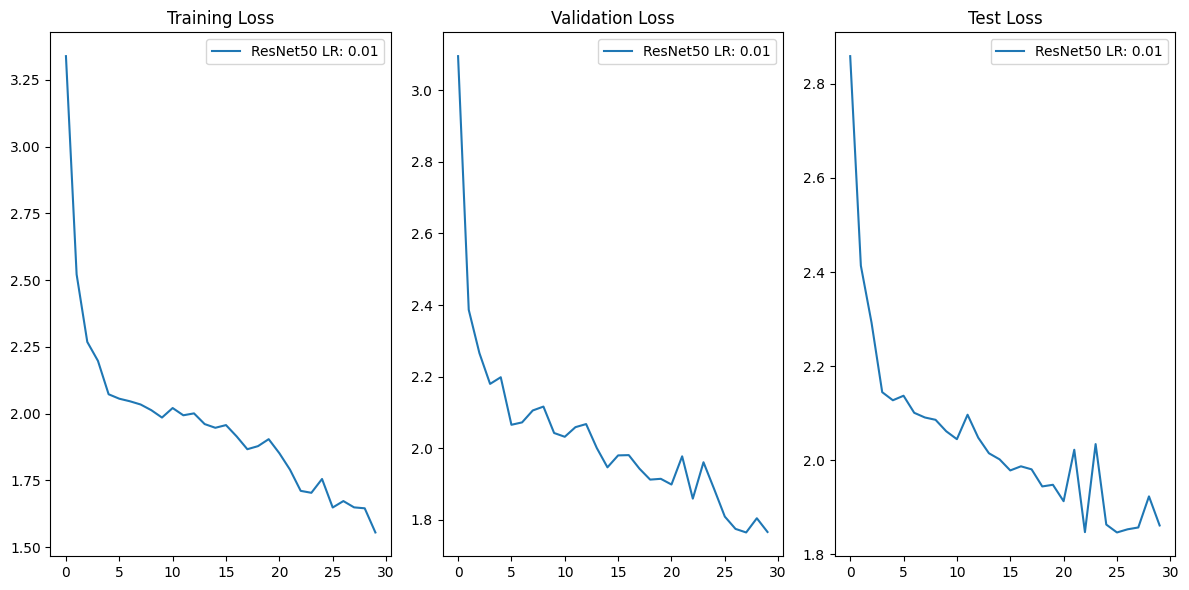

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses_resnet, label='ResNet50 LR: 0.01')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses_resnet, label='ResNet50 LR: 0.01')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_losses_resnet, label='ResNet50 LR: 0.01')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Q4: DenseNet121

In [ ]:
# Load the pretrained DenseNet121 model
densenet121_model = torchvision.models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1') # Use the ImageNet weights

# Enable GPU usage if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
densenet121_model.to(device)

densenet121_model.eval()

# Print the architecture for comparing to other architectures
print(densenet121_model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Modify the last layer (fully connected [fc] layer) for 10 classes (to match with CIFAR-10)
densenet121_model.classifier = nn.Linear(1024, 10)

epochs = 30
learning_rate_densenet121 = 0.01
train_losses_densenet121, val_losses_densenet121, test_losses_densenet121 = train_and_evaluate(densenet121_model, train_loader, val_loader, test_loader, learning_rate_densenet121, epochs)

Epoch 1/30, Train Loss: 3.3090, Val Loss: 2.6577, Test Loss: 2.5813
Epoch 2/30, Train Loss: 2.4278, Val Loss: 2.3871, Test Loss: 2.3953
Epoch 3/30, Train Loss: 2.4542, Val Loss: 2.3169, Test Loss: 2.3004
Epoch 4/30, Train Loss: 2.3190, Val Loss: 2.2644, Test Loss: 2.2135
Epoch 5/30, Train Loss: 2.1919, Val Loss: 2.4144, Test Loss: 2.4224
Epoch 6/30, Train Loss: 2.2463, Val Loss: 2.1565, Test Loss: 2.1746
Epoch 7/30, Train Loss: 2.0986, Val Loss: 2.1050, Test Loss: 2.1868
Epoch 8/30, Train Loss: 2.0737, Val Loss: 2.2144, Test Loss: 2.2928
Epoch 9/30, Train Loss: 2.0361, Val Loss: 2.0884, Test Loss: 2.1627
Epoch 10/30, Train Loss: 1.9428, Val Loss: 1.9647, Test Loss: 2.0618
Epoch 11/30, Train Loss: 1.9275, Val Loss: 1.9593, Test Loss: 2.1069
Epoch 12/30, Train Loss: 1.9266, Val Loss: 1.9438, Test Loss: 1.9508
Epoch 13/30, Train Loss: 1.9087, Val Loss: 1.9630, Test Loss: 1.9966
Epoch 14/30, Train Loss: 1.8774, Val Loss: 1.9125, Test Loss: 2.0195
Epoch 15/30, Train Loss: 1.7923, Val Loss: 

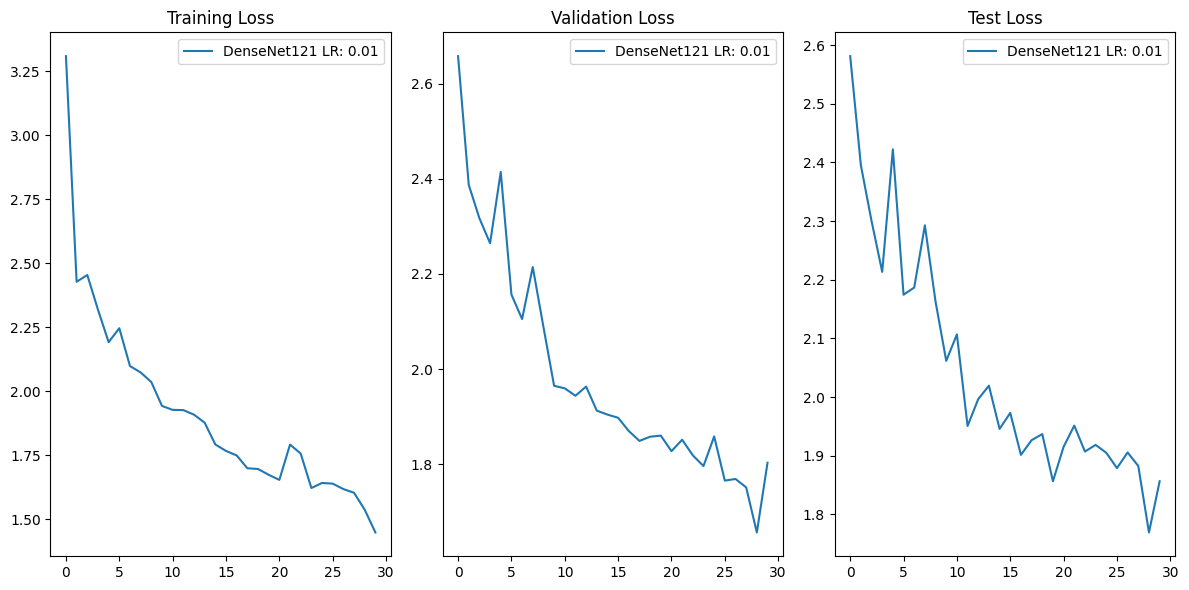

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses_densenet121, label='DenseNet121 LR: 0.01')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses_densenet121, label='DenseNet121 LR: 0.01')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_losses_densenet121, label='DenseNet121 LR: 0.01')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Q5: MoNet

My name 'Mohamed' and 'Net' = MoNet (like "Claude Monet" the artist!)

In [29]:
# Use Keras Sequential class to build model
monet_model = keras.Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32,32,3)), # Image dimensions (32x32x3)

    # Normalize input batches to each layer by centering and scaling the batch using its standard deviation and mean
    # This helps with the problem of "internal covariate shift" where the distributions of the activations for each feature can change/drift over time
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Decreased dropout to 0.2 from 0.5

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2), # Decreased dropout to 0.2 from 0.5

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2), # Decreased dropout to 0.2 from 0.5

    # Flatten the feature maps
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.2), # Decreased dropout to 0.2 from 0.5

    # Output Layer
    Dense(10, activation="softmax")
])

# Print the architecture for comparing to other architectures
monet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

**First tried with 40 epochs**

In [35]:
# Compile the model
# momentum adds part [0.9] of the previous update to the current update of the model parameters (results in quicker convergence)
monet_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Initialize losses lists to store for plotting
train_losses = []
val_losses = []
test_losses = []

# Define a callback to get the test_loss at the end of each epoch instead of just once at the end
class TestLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the test loss after each epoch
        test_loss, _ = self.model.evaluate(x_test_mini, y_test_mini, verbose=0)
        test_losses.append(test_loss)

# Train the model with the mini dataset
history = monet_model.fit(x_train_mini, y_train_mini,
          epochs=40, batch_size=16,                   # Changed batch size from 32 (default) to 16
          validation_data=(x_val_mini, y_val_mini),
          callbacks=[TestLossCallback()])

# Get the training and validation losses from the history object
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Evaluate on the test set
test_loss, test_acc = monet_model.evaluate(x_test_mini, y_test_mini)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6096 - loss: 1.2950 - val_accuracy: 0.6867 - val_loss: 0.9586
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5886 - loss: 1.3091 - val_accuracy: 0.7133 - val_loss: 0.9267
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5841 - loss: 1.2174 - val_accuracy: 0.7133 - val_loss: 0.9655
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5614 - loss: 1.2567 - val_accuracy: 0.6800 - val_loss: 0.9919
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6077 - loss: 1.2040 - val_accuracy: 0.6667 - val_loss: 1.0234
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5643 - loss: 1.1709 - val_accuracy: 0.7133 - val_loss: 0.9757
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6126 - loss: 1.1168 - val_accuracy: 0.7033 - val_loss: 0.9567
Epoch 8/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5806 - loss: 1.2052 - val_accuracy: 0.7200 - v

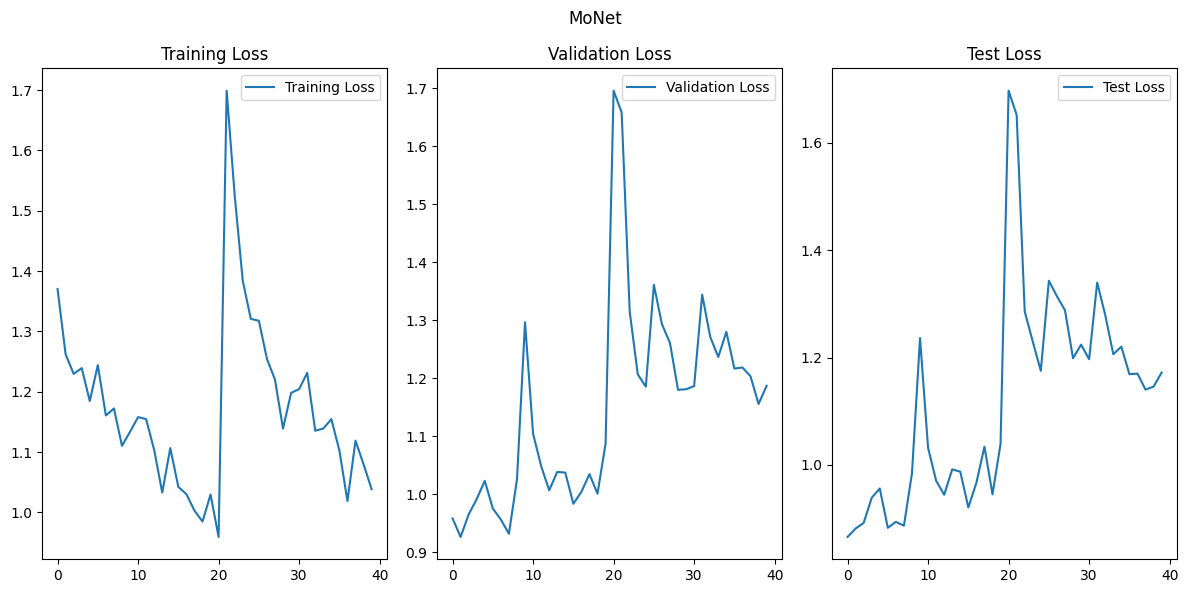

In [36]:
# Plotting
plt.figure(figsize=(12, 6))

# Training Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()

# Validation Loss Plot
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.legend()

# Test Loss Plot
plt.subplot(1, 3, 3)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.legend()
plt.suptitle('MoNet')
plt.tight_layout()
plt.show()

**Tried with less epochs too (10 epochs instead of 40)**

In [37]:
# Train the model with the mini dataset
history = monet_model.fit(x_train_mini, y_train_mini,
          epochs=10, batch_size=16,                   # Changed batch size from 32 (default) to 16
          validation_data=(x_val_mini, y_val_mini),
          callbacks=[TestLossCallback()])

# Get the training and validation losses from the history object
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Evaluate on the test set
test_loss, test_acc = monet_model.evaluate(x_test_mini, y_test_mini)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6315 - loss: 0.9562 - val_accuracy: 0.5800 - val_loss: 1.2435
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6406 - loss: 1.0098 - val_accuracy: 0.5200 - val_loss: 1.2991
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6553 - loss: 1.0014 - val_accuracy: 0.5433 - val_loss: 1.2931
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6725 - loss: 0.9358 - val_accuracy: 0.6200 - val_loss: 1.1773
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6834 - loss: 0.9467 - val_accuracy: 0.5700 - val_loss: 1.2497
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6513 - loss: 1.0076 - val_accuracy: 0.5600 - val_loss: 1.2867
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6853 - loss: 0.8998 - val_accuracy: 0.5833 - val_loss: 1.1995
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6764 - loss: 0.9668 - val_accuracy: 0.5667 - v

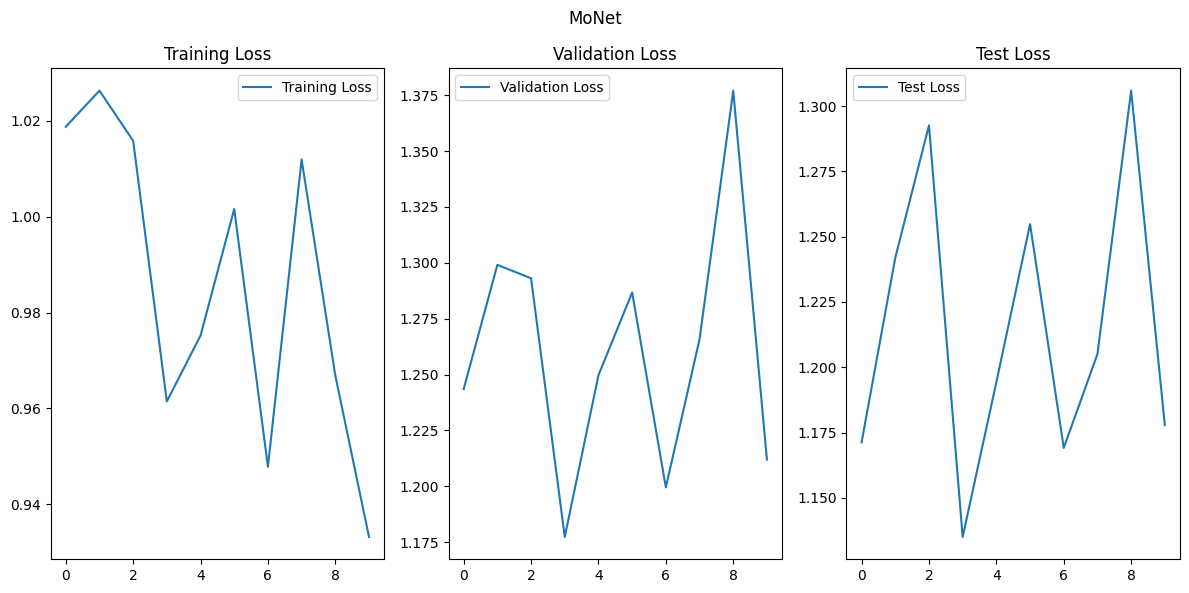

In [38]:
# Plotting
plt.figure(figsize=(12, 6))

# Training Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()

# Validation Loss Plot
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.legend()

# Test Loss Plot
plt.subplot(1, 3, 3)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.legend()
plt.suptitle('MoNet')
plt.tight_layout()
plt.show()